my trails on solving the [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting) comptetition

following [this guide](https://www.kaggle.com/code/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide)

Uses AB Testing, lag generator

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from prophet import Prophet

from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error
import plotly.express as px


from warnings import filterwarnings
filterwarnings('ignore')


In [2]:
def AB_Test(dataframe, group, target):
    """
    Conducts an A/B test to compare two groups and determine if there is a statistically significant difference in their means.

    Parameters:
        - dataframe: DataFrame containing the data.
        - group: Column name representing the group identifier (e.g., treatment vs. control).
        - target: Column name representing the metric or variable of interest.

    Returns:
        - A DataFrame with the A/B test results, including hypothesis outcomes, p-values, and group statistics.
    """
    
    # Step 1: Split Data into Groups (Group A and Group B)
    # Step 2: Check Normality Assumption
        # Step 3a: If Both Groups Are Normally Distributed, Check Homogeneity of Variances and Perform a Parametric t-test
        # Step 3b: If Either Group Is Not Normally Distributed, Perform a Non-Parametric Test
    # Step 4: Create a Summary DataFrame with Test Results and Group Statistics
    
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    dataframe=dataframe.dropna(axis=0)
    # Split A/B
    # print('dataframe shape',dataframe.shape)
    # print('dataframe columns',dataframe.columns)
    groupA = dataframe[dataframe[group] == 1][target]
    groupB = dataframe[dataframe[group] == 0][target]
    print('group A shape',groupA.shape)
    print('group B shape',groupB.shape)
    
    # ======= Assumption: Normality
    # Check for normality using the Shapiro-Wilk test
    # H0: Distribution is Normal (False if p-value < 0.05)
    # H1: Distribution is not Normal (True if p-value < 0.05)
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    
    if (ntA == False) & (ntB == False): # If both groups are normally distributed
        # Parametric Test
        # ======= Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            # Perform a parametric t-test assuming equal variances
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: Means are equal (False if p-value < 0.05)
            # H1: Means are not equal (True if p-value < 0.05)
        else:
            # Heterogeneous
            # Perform a parametric t-test assuming unequal variances
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: Means are equal (False if p-value < 0.05)
            # H1: Means are not equal (True if p-value < 0.05)
    else:
        # Non-Parametric Test
        # Perform Mann-Whitney U test (Wilcoxon rank-sum test)
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: Means are equal (False if p-value < 0.05)
        # H1: Means are not equal (True if p-value < 0.05)
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":f'{ttest:.2e}'
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    temp["Feature"] = group
    temp["GroupA_mean"] = groupA.mean()
    temp["GroupB_mean"] = groupB.mean()
    temp["GroupA_median"] = groupA.median()
    temp["GroupB_median"] = groupB.median()
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Feature","Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
    else:
        temp = temp[["Feature","Test Type","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
    return temp

In [3]:

train=pd.read_csv('data/train.csv')
stores=pd.read_csv('data/stores.csv')
# oil=pd.read_csv('data/oil.csv')
# samp=pd.read_csv('data/sample_submission.csv')
# trans=pd.read_csv('data/transactions.csv')
test=pd.read_csv('data/test.csv')
holidays=pd.read_csv('data/holidays_events.csv')



In [4]:
train.date=pd.to_datetime(train.date)
test.date=pd.to_datetime(test.date)

# train.set_index('date',inplace=True)
# test.set_index('date',inplace=True)
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
size=int(len(train.index.unique())*0.8)*train.store_nbr.nunique()*train.family.nunique()
X=train.copy()
# X.drop('id',axis=1,inplace=True)
X.set_index('id',inplace=True)
y=X.pop('sales')
X_train=X.iloc[:size]
X_test=X.iloc[size:]
y_train=y.iloc[:size]
y_test=y.iloc[size:]
X_train=pd.get_dummies(X_train,columns=['store_nbr','family'])
X_test=pd.get_dummies(X_test,columns=['store_nbr','family'])


In [6]:
X

,date,store_nbr,family,onpromotion
id,,,,
0,2013-01-01,1,AUTOMOTIVE,0
1,2013-01-01,1,BABY CARE,0
2,2013-01-01,1,BEAUTY,0
3,2013-01-01,1,BEVERAGES,0
4,2013-01-01,1,BOOKS,0
...,...,...,...,...
3000883,2017-08-15,9,POULTRY,0
3000884,2017-08-15,9,PREPARED FOODS,1
3000885,2017-08-15,9,PRODUCE,148


In [7]:
df2=train.set_index('id')

df3=df2.groupby([pd.Grouper(key='date',freq='d'),'store_nbr']).mean(numeric_only=True).reset_index('store_nbr')
df3=df3.loc['2016']
df3

,store_nbr,sales,onpromotion
date,,,
2016-01-01,1,0.000000,0.000000
2016-01-01,2,0.000000,0.000000
2016-01-01,3,0.000000,0.000000
2016-01-01,4,0.000000,0.000000
2016-01-01,5,0.000000,0.000000
...,...,...,...
2016-12-31,50,730.729758,11.151515
2016-12-31,51,895.957455,9.969697
2016-12-31,52,0.000000,0.000000


In [8]:
px.line(df3.sales,color=df3.store_nbr)

In [9]:
c=df2.groupby([df2.store_nbr,pd.Grouper(key='date',freq='d')]).sum(numeric_only=True)
opendates=[]
for i in range(1,55):
    d=c.loc[i]
    res=np.nan
    for r in d.index:
        if d.loc[r,'sales']!=0:
            break
        else:
            res=r
    opendates.append(pd.DataFrame(
        {'store_nbr':[i],
         'date':res}
    ))
opendates=pd.concat(opendates)
opendates.head()

,store_nbr,date
0,1,2013-01-01
0,2,2013-01-01
0,3,2013-01-01
0,4,2013-01-01
0,5,2013-01-01


In [10]:
px.line(df2[df2.store_nbr==52].groupby(pd.Grouper(key='date',freq='1d')).sum().loc['2017'].sales)

In [11]:
for i,r in opendates.iterrows():
    d_f=df2[~((df2.store_nbr==r.store_nbr) &(df2.date<r.date))]

In [12]:
# never sold
c=d_f.groupby(['store_nbr','family']).sum(numeric_only=True).reset_index()
c=c[c.sales==0]
c.head()

,store_nbr,family,sales,onpromotion
1,1,BABY CARE,0.0,0
268,9,BOOKS,0.0,0
301,10,BOOKS,0.0,0
334,11,BOOKS,0.0,0
367,12,BOOKS,0.0,0


In [13]:
df2__=df2.copy()

In [14]:
# my method (takes 14 seconds)
# df2_=df2.copy()
# for i,r in c.iterrows():
#     df2_=df2_[~((df2_.store_nbr==r.store_nbr)&(df2_.family==r.family))]
# df2_

# kaggle method (takes 1 second!!)
df2_=d_f.copy()
d = df2_.reset_index().merge(c, how = 'outer', indicator = True)
df2 = d[~(d._merge == 'both')].drop('_merge', axis = 1)

df2

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,10692,2013-01-07,1,AUTOMOTIVE,0.000,0
2,30294,2013-01-18,1,AUTOMOTIVE,0.000,0
3,40986,2013-01-24,1,AUTOMOTIVE,0.000,0
4,53460,2013-01-31,1,AUTOMOTIVE,0.000,0
...,...,...,...,...,...,...
3000883,3000879,2017-08-15,9,MEATS,449.228,0
3000884,3000880,2017-08-15,9,PERSONAL CARE,522.000,11
3000885,3000883,2017-08-15,9,POULTRY,438.133,0
3000886,3000884,2017-08-15,9,PREPARED FOODS,154.553,1


In [15]:
zeropred=[]
for i,r in c.iterrows():
    zeropred.append(
        pd.DataFrame({
            'date':pd.date_range('2017-08-16','2017-08-31'),
            'store_nbr':r.store_nbr,
            'family':r.family,
            'sales':0
        })
    )
zeropred=pd.concat(zeropred)
zeropred

,date,store_nbr,family,sales
0,2017-08-16,1,BABY CARE,0
1,2017-08-17,1,BABY CARE,0
2,2017-08-18,1,BABY CARE,0
3,2017-08-19,1,BABY CARE,0
4,2017-08-20,1,BABY CARE,0
...,...,...,...,...
11,2017-08-27,54,LAWN AND GARDEN,0
12,2017-08-28,54,LAWN AND GARDEN,0
13,2017-08-29,54,LAWN AND GARDEN,0
14,2017-08-30,54,LAWN AND GARDEN,0


In [16]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [17]:
df3=df2.merge(stores)
stores
for c in holidays.drop(['date','description'],axis=1).columns:
    print(c,holidays[c].unique())
    
holidays.columns

type ['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
locale ['Local' 'Regional' 'National']
locale_name ['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']
transferred [False  True]


Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')

In [18]:

h1=holidays.copy()
h1.date=pd.to_datetime(h1.date)
h1=h1[~((h1.type=='Work Day')|(h1.transferred==True))]
h1.type=1

local=h1[h1.locale=='Local'][['type','date','locale_name']].rename(columns={'locale_name':'city'})
regional=h1[h1.locale=='Regional'][['type','date','locale_name']].rename(columns={'locale_name':'state'})
national=h1[h1.locale=='National'][['type','date']]
h1.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,1,Local,Manta,Fundacion de Manta,False
1,2012-04-01,1,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,1,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,1,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,1,Local,Riobamba,Cantonizacion de Riobamba,False


In [19]:
h1.dtypes

date           datetime64[ns]
type                    int64
locale                 object
locale_name            object
description            object
transferred              bool
dtype: object

In [20]:
train1=train.copy()

tf=pd.concat([train1,test]).reset_index(drop=True)
tf=tf.merge(stores)
tf=tf.merge(local,on=['date','city'],how='left',suffixes=('','_l'))
tf=tf.merge(regional,on=['date','state'],how='left',suffixes=('','_r'))
tf=tf.merge(national,on='date',how='left',suffixes=('','_n'))
tf['holiday']=tf[['type_l','type_r','type_n']].sum(axis=1)
tf=tf.drop(['type_l','type_r','type_n'],axis=1)
tf


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,1.0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,1.0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,1.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,1.0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3036787,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,0.0
3036788,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,0.0
3036789,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,0.0
3036790,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,0.0


In [21]:
# AB_Test(tf,'sales','holiday')
AB_Test(tf,'holiday','sales')

# tf[tf['holiday'] == 1]['sales'].shape
# tf[tf['holiday'] == 0]['sales'].shape


group A shape (252879,)
group B shape (2754972,)


,Feature,Test Type,AB Hypothesis,p-value,Comment,GroupA_mean,GroupB_mean,GroupA_median,GroupB_median
0,holiday,Non-Parametric,Reject H0,1.99e-151,A/B groups are not similar!,425.356686,352.130549,13.0,11.0


In [22]:
tf

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,1.0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,1.0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,1.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,1.0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3036787,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,0.0
3036788,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,0.0
3036789,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,0.0
3036790,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,0.0


In [23]:

from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
sc=StandardScaler()
oe=OrdinalEncoder()


In [24]:
# Time Related Features

# X=tf.dropna()
def create_date_features(df):
    temp=df.copy()
    temp['month'] = temp.date.dt.month.astype("int8")
    temp['day_of_month'] = temp.date.dt.day.astype("int8")
    temp['day_of_year'] = temp.date.dt.dayofyear.astype("int16")
    # temp['week_of_month'] = (temp.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    # temp['week_of_year'] = (temp.date.dt.weekofyear).astype("int8")
    temp['day_of_week'] = (temp.date.dt.dayofweek + 1).astype("int8")
    # temp['year'] = temp.date.dt.year.astype("int32")
    temp["is_wknd"] = (temp.date.dt.weekday // 4).astype("int8")
    # temp["quarter"] = temp.date.dt.quarter.astype("int8")
    # temp['is_month_start'] = temp.date.dt.is_month_start.astype("int8")
    # temp['is_month_end'] = temp.date.dt.is_month_end.astype("int8")
    # temp['is_quarter_start'] = temp.date.dt.is_quarter_start.astype("int8")
    # temp['is_quarter_end'] = temp.date.dt.is_quarter_end.astype("int8")
    # temp['is_year_start'] = temp.date.dt.is_year_start.astype("int8")
    temp['is_year_end'] = temp.date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    # temp["season"] = np.where(temp.month.isin([12,1,2]), 0, 1)
    # temp["season"] = np.where(temp.month.isin([6,7,8]), 2, temp["season"])
    # temp["season"] = pd.Series(np.where(temp.month.isin([9, 10, 11]), 3, temp["season"])).astype("int8")
    return temp

def lag_generator(df, column, lag_value, groupby_columns=None):
    """
    Generate a lagged version of a column in a DataFrame based on specified grouping columns.

    Parameters:
        - df: DataFrame to operate on.
        - column: Name of the column to be lagged.
        - lag_value: Number of periods to lag the column by (e.g., 1 for one period back).
        - groupby_columns: List of column names for grouping (e.g., ['product_family', 'store_nbr']).

    Returns:
        - DataFrame with the lagged column added.
    """
    temp=df.copy()
    if groupby_columns is None:
        # If no grouping columns are specified, apply the lag directly to the entire column
        temp[f'{column}_lag_{lag_value}'] = temp[column].shift(lag_value)
    else:
        # If grouping columns are specified, group the DataFrame and apply lag within each group
        grouped = temp.groupby(groupby_columns)
        temp[f'{column}_lag_{lag_value}'] = grouped[column].shift(lag_value)
    
    return temp


X preperation

In [25]:
def preprocess(df):
    X=df.copy()
    X=create_date_features(X)
    X=lag_generator(X,'sales',2,['store_nbr','family'])
    X=lag_generator(X,'sales',365,['store_nbr','family'])
    X=lag_generator(X,'sales',730,['store_nbr','family'])
    return X

In [106]:
X=tf.copy()
X=preprocess(X)
X=X.drop(['month','day_of_month','city','state'],axis=1)
X.head()

,id,date,store_nbr,family,sales,onpromotion,type,cluster,holiday,day_of_year,day_of_week,is_wknd,is_year_end,sales_lag_2,sales_lag_365,sales_lag_730
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,D,13,1.0,1,2,0,0,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,D,13,1.0,1,2,0,0,NaN,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,D,13,1.0,1,2,0,0,NaN,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,D,13,1.0,1,2,0,0,NaN,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,D,13,1.0,1,2,0,0,NaN,NaN,NaN


In [109]:
X2=X.copy()
# X2.groupby('store_nbr')
# X2=X2.drop(['type'],axis=1).loc[X2.store_nbr==1].groupby([pd.Grouper(key='date',freq='d')]).mean(numeric_only=True).set_index('id')
X2=X2.drop(['type'],axis=1).groupby([pd.Grouper(key='date',freq='d')]).mean(numeric_only=True).set_index('id')
X2

,store_nbr,sales,onpromotion,cluster,holiday,day_of_year,day_of_week,is_wknd,is_year_end,sales_lag_2,sales_lag_365,sales_lag_730
id,,,,,,,,,,,,
890.5,27.5,1.409438,0.000000,8.481481,1.0,1.0,2.0,0.0,0.0,NaN,NaN,NaN
2672.5,27.5,278.390807,0.000000,8.481481,0.0,2.0,3.0,0.0,0.0,NaN,NaN,NaN
4454.5,27.5,202.840197,0.000000,8.481481,0.0,3.0,4.0,0.0,0.0,1.409438,NaN,NaN
6236.5,27.5,198.911154,0.000000,8.481481,0.0,4.0,5.0,1.0,0.0,278.390807,NaN,NaN
8018.5,27.5,267.873244,0.000000,8.481481,0.0,5.0,6.0,1.0,0.0,202.840197,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3021380.5,27.5,NaN,5.778339,8.481481,0.0,239.0,7.0,1.0,0.0,NaN,362.905877,499.778123
3023162.5,27.5,NaN,4.763749,8.481481,0.0,240.0,1.0,0.0,0.0,NaN,443.909952,532.047359
3024944.5,27.5,NaN,6.103255,8.481481,0.0,241.0,2.0,0.0,0.0,NaN,481.931773,444.077419


In [111]:
X2.loc[X2.index>=3000888.0]


,store_nbr,sales,onpromotion,cluster,holiday,day_of_year,day_of_week,is_wknd,is_year_end,sales_lag_2,sales_lag_365,sales_lag_730
id,,,,,,,,,,,,
3001778.5,27.5,NaN,17.137486,8.481481,0.000000,228.0,3.0,0.0,0.0,427.004717,404.058530,354.055964
3003560.5,27.5,NaN,4.211560,8.481481,0.000000,229.0,4.0,0.0,0.0,427.980884,403.294978,359.337442
3005342.5,27.5,NaN,7.731201,8.481481,0.000000,230.0,5.0,1.0,0.0,NaN,407.376938,325.926274
3007124.5,27.5,NaN,4.833895,8.481481,0.000000,231.0,6.0,1.0,0.0,NaN,323.990191,375.519244
3008906.5,27.5,NaN,5.338384,8.481481,0.000000,232.0,7.0,1.0,0.0,NaN,380.901861,458.107260
3010688.5,27.5,NaN,4.545455,8.481481,0.000000,233.0,1.0,0.0,0.0,NaN,465.199964,468.680980
3012470.5,27.5,NaN,5.777217,8.481481,0.000000,234.0,2.0,0.0,0.0,NaN,506.099972,381.793520
3014252.5,27.5,NaN,9.259259,8.481481,0.000000,235.0,3.0,0.0,0.0,NaN,401.159503,352.047885
3016034.5,27.5,NaN,4.639731,8.481481,0.037037,236.0,4.0,0.0,0.0,NaN,370.830515,349.731008


In [112]:
X=X2.copy()
# X_train=X[~X.sales.isna()]
# X_test=X[X.sales.isna()]
X_train=X.loc[X2.index<3000888.0]
X_test=X.loc[X2.index>=3000888.0]
X_test=X_test.drop('sales',axis=1)
y_train=X_train.pop('sales')

In [113]:
catcol=X.select_dtypes('object').columns
num=['day_of_year']
# oe.fit_transform(X[catcol])

transformer=ColumnTransformer([
    ('cat',oe,catcol),
    ('DoY',sc,num)
    
],remainder='passthrough')

X_p=pd.DataFrame(index=X_train.index,columns=X_train.columns,data=transformer.fit_transform(X_train))


In [114]:
from xgboost import XGBRegressor
model=XGBRegressor()
model.fit(X_p,y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [115]:
X_t_p=transformer.transform(X_test)

y_fit=model.predict(X_p)
y_pred=model.predict(X_t_p)

y_fit=pd.Series(y_fit,index=X_train.index)
y_pred=pd.Series(y_pred,index=X_test.index)

date
2017-08-16   NaN
2017-08-17   NaN
2017-08-18   NaN
2017-08-19   NaN
2017-08-20   NaN
Name: sales, dtype: float64
date
2013-01-01    0.0
2013-01-02    2.0
2013-01-03    3.0
2013-01-04    3.0
2013-01-05    5.0
Name: sales, dtype: float64


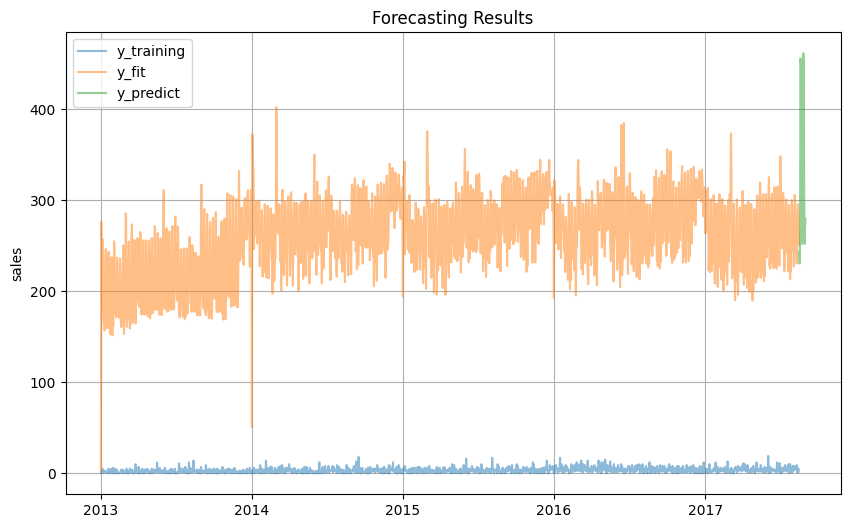

In [116]:
import matplotlib.pyplot as plt

def plot_forecasting_results(dataframe, model, conditions, y_column):
    """
    Plot forecasting results (y_training, y_testing, y_predict) based on given conditions.

    Parameters:
        - dataframe: DataFrame containing the data.
        - model: A forecasting model that has a `predict` method.
        - conditions: Dictionary containing filtering conditions (e.g., {'store_nbr': 1, 'product_family': 'Electronics'}).
        - y_column: Name of the y-column for plotting.

    Returns:
        - None (plots the results).
    """
    # Apply filtering conditions to the DataFrame
    filtered_data = dataframe.copy()
    filtered_data= preprocess(filtered_data)
    filtered_data=filtered_data.set_index('date')
    # print(filtered_data.head())
    # print(filtered_data.columns)
    for column, value in conditions.items():
        filtered_data = filtered_data[filtered_data[column] == value]
    
    # Split data into training and testing
    # Modify this based on your data splitting method (e.g., time-based split)
    train_data = filtered_data[~filtered_data[y_column].isna()]
    test_data = filtered_data[filtered_data[y_column].isna()]

    # Extract training, testing, and prediction data
    X_train = train_data.drop(columns=[y_column])
    X_test = test_data.drop(columns=[y_column])
    y_train = train_data[y_column]
    y_test = test_data[y_column]
    
    print(y_test.head())
    print(y_train.head())
    
    X_train=transformer.transform(X_train)
    X_test=transformer.transform(X_test)
    y_fit = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    y_fit=pd.Series(y_fit,index=train_data.index)
    y_pred=pd.Series(y_pred,index=test_data.index)
    # y_pred.index=X_test.index

    # Create a time or index variable for plotting
    # Modify this if your DataFrame contains a datetime or other index
    time = range(len(y_train), len(y_train) + len(y_test))
    
    # Plot y_training, y_testing, and y_predict
    plt.figure(figsize=(10, 6))
    # plt.plot(time, y_train, label='y_training', marker='o')
    # plt.plot(time, y_test, label='y_testing', marker='o')
    # plt.plot(time, y_pred, label='y_predict', marker='o')
    # print(y_pred.head())
    a=0.5
    plt.plot( y_train, label='y_training',alpha=a)
    plt.plot( y_fit, label='y_fit',alpha=a)
    plt.plot( y_pred, label='y_predict',alpha=a)
    
    # plt.xlabel('Time (or Index)')
    plt.ylabel(y_column)
    plt.title('Forecasting Results')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Replace 'YourDataFrame' and 'YourModel' with your DataFrame and forecasting model.
# Specify the filtering conditions and y-column accordingly.
# plot_forecasting_results(YourDataFrame, YourModel, {'store_nbr': 1, 'product_family': 'Electronics'}, 'sales')
plot_forecasting_results(tf, model, {'store_nbr':1,'family':'AUTOMOTIVE'}, 'sales')

In [117]:
trn=X_train.merge(y_train,left_index=True,right_index=True)
# tst=X_test.merge(y_test,left_index=True,right_index=True)
tst=X_test
fitt=pd.Series(model.predict(X_train),name='Fit',index=X_train.index)
pred=pd.Series(model.predict(X_test),name='Pred',index=X_test.index)
# res=pd.concat([X_train,X_test])
# res
res=pd.concat([trn,tst])
res=res.merge(fitt,left_index=True,right_index=True,how='outer')
res=res.merge(pred,left_index=True,right_index=True,how='outer')
res
px.line(res[['sales',	'Fit',	'Pred',]])



In [177]:
t2=train.copy()
t2.date=t2.date.dt.to_period('D')
sales=t2.set_index(['store_nbr','family','date']).sort_index()
family=(t2.groupby(['family','date'])
        .mean(numeric_only=True)[['sales','onpromotion']]
        .unstack('family')
        .loc['2017']
        )
sales

id  sales  onpromotion
store_nbr family     date                                   
1         AUTOMOTIVE 2013-01-01        0    0.0            0
                     2013-01-02     1782    2.0            0
                     2013-01-03     3564    3.0            0
                     2013-01-04     5346    3.0            0
                     2013-01-05     7128    5.0            0
...                                  ...    ...          ...
54        SEAFOOD    2017-08-11  2993627    0.0            0
                     2017-08-12  2995409    1.0            1
                     2017-08-13  2997191    2.0            0
                     2017-08-14  2998973    0.0            0
                     2017-08-15  3000755    3.0            0

[3000888 rows x 3 columns]

In [178]:
mag=family.loc[:,(['sales','onpromotion'],'MAGAZINES')]
mag.columns=['sales','onpromotion']
mag

,sales,onpromotion
date,,
2017-01-01,0.074074,0.0
2017-01-02,7.777778,0.0
2017-01-03,3.500000,0.0
2017-01-04,3.500000,0.0
2017-01-05,3.203704,0.0
...,...,...
2017-08-11,9.259259,0.0
2017-08-12,8.944444,0.0
2017-08-13,8.685185,0.0


In [179]:
family.loc(axis=1)[:, 'MAGAZINES']

,sales,onpromotion
family,MAGAZINES,MAGAZINES
date,,
2017-01-01,0.074074,0.0
2017-01-02,7.777778,0.0
2017-01-03,3.500000,0.0
2017-01-04,3.500000,0.0
2017-01-05,3.203704,0.0
...,...,...
2017-08-11,9.259259,0.0
2017-08-12,8.944444,0.0
